In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd

import mne
import numpy as np
from mne.datasets import sample


from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
from mne.io import read_raw_eeglab

# MNE Example

In [ ]:
fs = 250  # sampling rate (Hz)
n_e = 300  # number of epochs
T = 10  # length of epochs (s)
f = 10  # frequency of sinusoids (Hz)
t = np.arange(0, T, 1 / fs)
A = 1  # noise amplitude
sigma = 0.5  # Gaussian noise variance

data = []

phase_differences = [0, -np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
for ps in zip(phase_differences):
    sig = []
    for _ in range(n_e):
        sig.append(
            np.sin(2 * np.pi * f * t - ps)
            + A * np.random.normal(0, sigma, size=t.shape)
        )
    data.append(sig)

data = np.swapaxes(np.array(data), 0, 1)  # make epochs the first dimension

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(t[:fs], data[0, 0, :fs], label="Reference")
ax[0].plot(t[:fs], data[0, 2, :fs])

ax[0].set_title(r"Phase Lagging ($-\pi/2$ Phase Difference)")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal")
ax[0].legend()

ax[1].plot(t[:fs], data[0, 0, :fs], label="Reference")
ax[1].plot(t[:fs], data[0, 4, :fs])
ax[1].set_title(r"Phase Leading ($\pi/2$ Phase Difference)")
ax[1].set_xlabel("Time (s)")

plt.show()

In [ ]:
conn = []
indices = ([0, 0, 0, 0, 0], [1, 2, 3, 4, 5])
for method in ["pli", "wpli", "dpli"]:
    conn.append(
        spectral_connectivity_epochs(
            data,
            method=method,
            sfreq=fs,
            indices=indices,
            fmin=9,
            fmax=11,
            faverage=True,
        )
    )

conn = [c.get_data()[:, 0] for c in conn]
conn = np.array(conn)

In [ ]:
x = np.arange(5)

plt.figure()
plt.bar(x - 0.2, conn[0], 0.2, align="center", label="PLI")
plt.bar(x, conn[1], 0.2, align="center", label="wPLI")
plt.bar(x + 0.2, conn[2], 0.2, align="center", label="dPLI")

plt.title("Connectivity Estimation Comparison")
plt.xticks(x, (r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"))
plt.legend()
plt.xlabel("Phase Difference")
plt.ylabel("Estimated Connectivity")

plt.show()

In [ ]:
n_noise = 41  # amount of noise amplitude samples in [0, 4]
data = [[]]

# Generate reference
for _ in range(n_e):
    data[0].append(np.sin(2 * np.pi * f * t))

A_list = np.linspace(0, 4, n_noise)

for A in A_list:
    sig = []
    # Generate other signal
    for _ in range(int(n_e / 2)):  # phase difference -pi/100
        sig.append(
            np.sin(2 * np.pi * f * t + np.pi / 100 + A * np.random.uniform(-1, 1))
        )
    for _ in range(int(n_e / 2), n_e):  # phase difference pi/2
        sig.append(np.sin(2 * np.pi * f * t - np.pi / 2 + A * np.random.uniform(-1, 1)))
    data.append(sig)

data = np.swapaxes(np.array(data), 0, 1)

# Visualize the data
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax[0].plot(t[:10], data[0, 0, :10], label="Reference")
ax[0].plot(t[:10], data[1, 1, :10])

ax[0].set_title(r"Phase Lagging ($-\pi/100$ Phase Difference)")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal")
ax[0].legend()

ax[1].plot(t[:fs], data[0, 0, :fs], label="Reference")
ax[1].plot(t[:fs], data[-1, 1, :fs])
ax[1].set_title(r"Phase Leading ($\pi/2$ Phase Difference)")
ax[1].set_xlabel("Time (s)")

plt.show()

In [ ]:
conn = []
indices = ([0] * n_noise, np.arange(1, n_noise + 1))
for method in ["pli", "wpli"]:
    conn.append(
        spectral_connectivity_epochs(
            data,
            method=method,
            sfreq=fs,
            indices=indices,
            fmin=9,
            fmax=11,
            faverage=True,
        ).get_data()[:, 0]
    )
conn = np.array(conn)

In [ ]:
plt.figure()
plt.plot(A_list, conn[0], "o-", label="PLI")
plt.plot(A_list, conn[1], "o-", label="wPLI")
plt.legend()
plt.xlabel("Noise Amplitude")
plt.ylabel("Connectivity Measure")
plt.title("wPLI and PLI Under Increasing Noise")
plt.show()

# Implement method on our data

In [2]:
# Load data

input_fnames = {
    "pre": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.set",
    ],
    "break": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_RELAX.set",
    ],
    "post": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.set",
        # "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.set",
    ],
}

epoch_length = 5
overlap = 0.3
eog = ()

pre_raws = []
for input_fname in input_fnames["pre"]:
    raw = read_raw_eeglab(
        input_fname=input_fname,
        eog=eog,
        preload=True,
        montage_units="mm",
        verbose=True,
    )
    raw.rename_channels(lambda x: x.strip("."))
    raw.rename_channels(
        mapping={
            "FPZ": "Fpz",
            "OZ": "Oz",
            "FP1": "Fp1",
            "FP2": "Fp2",
            "FZ": "Fz",
            "FCZ": "FCz",
            "CPZ": "CPz",
            "PZ": "Pz",
            "POZ": "POz",
        }
    )
    raw.drop_channels(["FT11", "F12", "F11"])
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    pre_raws.append(raw)

post_raws = []
for input_fname in input_fnames["post"]:
    raw = read_raw_eeglab(
        input_fname=input_fname,
        eog=eog,
        preload=True,
        montage_units="mm",
        verbose=True,
    )
    raw.rename_channels(lambda x: x.strip("."))
    # ['FP1', 'FP2', 'FZ', 'FCZ', 'CPZ', 'PZ', 'POZ'].
    raw.rename_channels(
        mapping={
            "FPZ": "Fpz",
            "OZ": "Oz",
            "FP1": "Fp1",
            "FP2": "Fp2",
            "FZ": "Fz",
            "FCZ": "FCz",
            "CPZ": "CPz",
            "PZ": "Pz",
            "POZ": "POz",
        }
    )
    raw.drop_channels(["FT11", "F12", "F11"])
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    post_raws.append(raw)

len(pre_raws), len(post_raws)


def extract_metadata(raw, stage: str = "pre"):
    metadata = {
        "stage": stage,
        "filename": os.path.basename(raw.filenames[0]),
        "n_channels": len(raw.info["ch_names"]),
        "duration": raw.times[-1],  # in seconds
        "sample_rate": raw.info["sfreq"],
    }
    return metadata


metadata = [extract_metadata(raw=raw) for raw in pre_raws] + [
    extract_metadata(raw=raw, stage="post") for raw in post_raws
]

columns = ["stage", "filename", "n_channels", "duration", "sample_rate"]
metadata = pd.DataFrame(metadata, columns=columns)

Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.fdt
Reading 0 ... 70749  =      0.000 ...   141.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(


Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.fdt
Reading 0 ... 60499  =      0.000 ...   120.998 secs...
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.fdt
Reading 0 ... 45999  =      0.000 ...    91.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:27: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct

Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.fdt
Reading 0 ... 50999  =      0.000 ...   101.998 secs...
Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.fdt
Reading 0 ... 79249  =      0.000 ...   158.498 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct

Reading /Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.fdt
Reading 0 ... 46999  =      0.000 ...    93.998 secs...


/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_72618/1715636727.py:55: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(
/var/folders/r3/bw3cwm6125lcm5h399

In [3]:
# based on the lowet duration make new raw data
# first we need to ignore the first and last 10 seconds of the data
# then take 70 seconds of the data

pre_raws = [raw.crop(tmin=10, tmax=raw.times[-1] - 10) for raw in pre_raws]
post_raws = [raw.crop(tmin=10, tmax=raw.times[-1] - 10) for raw in post_raws]

pre_raws = [raw.crop(tmin=0, tmax=70) for raw in pre_raws]
post_raws = [raw.crop(tmin=0, tmax=70) for raw in post_raws]

modified_metadata = [extract_metadata(raw=raw) for raw in pre_raws] + [
    extract_metadata(raw=raw, stage="post") for raw in post_raws
]

columns = ["stage", "filename", "n_channels", "duration", "sample_rate"]
modified_metadata = pd.DataFrame(modified_metadata, columns=columns)

In [4]:
# convert the raw data to arrays

pre_data = np.array([raw.get_data() for raw in pre_raws])
post_data = np.array([raw.get_data() for raw in post_raws])

pre_data.shape, post_data.shape

((3, 55, 35001), (3, 55, 35001))

In [5]:
sfreq = pre_raws[0].info["sfreq"]
fmin = 8
fmax = 50
tmin = 0

pre_con_wpli = spectral_connectivity_epochs(
    pre_data,
    method="wpli",
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,  # Average connectivity scores for each frequency band. If True, the output freqs will be a list with arrays of the frequencies that were averaged.
    tmin=tmin,
    mt_adaptive=False,  # Use adaptive weights for multitaper
    n_jobs=-1,
)

post_con_wpli = spectral_connectivity_epochs(
    post_data,
    method="wpli",
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    tmin=tmin,
    mt_adaptive=False,
    n_jobs=-1,
)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1485 connections
    using t=0.000s..70.000s for estimation (35001 points)
    frequencies: 8.0Hz..50.0Hz (2940 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epochs 1..1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


    computing cross-spectral density for epochs 2..2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


    computing cross-spectral density for epochs 3..3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1485 connections
    using t=0.000s..70.000s for estimation (35001 points)
    frequencies: 8.0Hz..50.0Hz (2940 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epochs 1..1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


    computing cross-spectral density for epochs 2..2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


    computing cross-spectral density for epochs 3..3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


    assembling connectivity matrix
[Connectivity computation done]


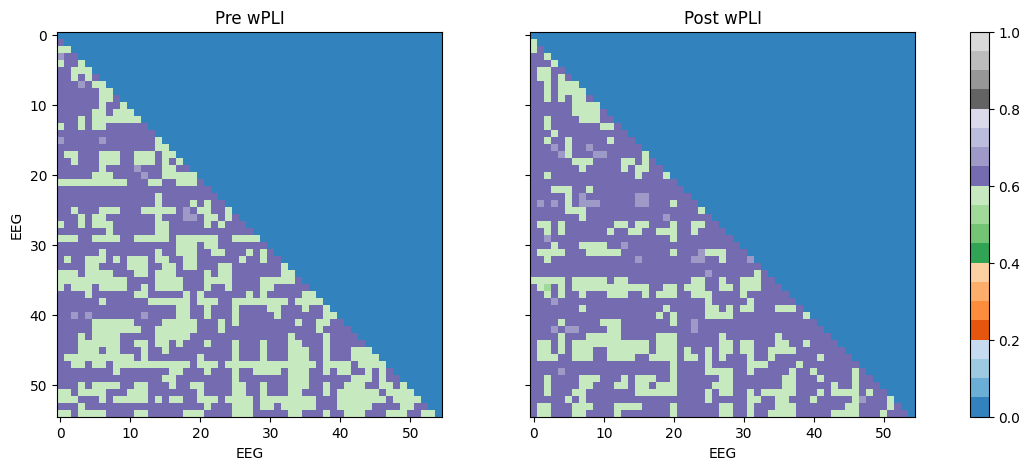

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs[0].imshow(pre_con_wpli.get_data("dense")[:, :, 0], vmin=0, vmax=1, cmap='tab20c')
axs[0].set_title("Pre wPLI")
axs[0].set_ylabel("EEG")
axs[0].set_xlabel("EEG")

im = axs[1].imshow(post_con_wpli.get_data("dense")[:, :, 0], vmin=0, vmax=1, cmap='tab20c')
axs[1].set_title("Post wPLI")
axs[1].set_xlabel("EEG")

fig.colorbar(im, ax=axs.ravel())
plt.show()

# Visualization

## visualize it using a circular graph 

In [ ]:
# Author: Annalisa Pascarella <a.pascarella@iac.cnr.it>
#
# License: BSD (3-clause)

import os.path as op

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne import make_forward_solution, setup_source_space, setup_volume_source_space
from mne.datasets import sample
from mne.io import read_raw_fif
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.viz import circular_layout

from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

# Set directories
data_path = sample.data_path()
subject = "sample"
data_dir = op.join(data_path, "MEG", subject)
subjects_dir = op.join(data_path, "subjects")
bem_dir = op.join(subjects_dir, subject, "bem")

# Set file names
fname_aseg = op.join(subjects_dir, subject, "mri", "aseg.mgz")

fname_model = op.join(bem_dir, "%s-5120-bem.fif" % subject)
fname_bem = op.join(bem_dir, "%s-5120-bem-sol.fif" % subject)

fname_raw = op.join(data_dir, "sample_audvis_filt-0-40_raw.fif")
fname_trans = op.join(data_dir, "sample_audvis_raw-trans.fif")
fname_cov = op.join(data_dir, "ernoise-cov.fif")
fname_event = op.join(data_dir, "sample_audvis_filt-0-40_raw-eve.fif")

# List of sub structures we are interested in. We select only the
# sub structures we want to include in the source space
labels_vol = [
    "Left-Amygdala",
    "Left-Thalamus-Proper",
    "Left-Cerebellum-Cortex",
    "Brain-Stem",
    "Right-Amygdala",
    "Right-Thalamus-Proper",
    "Right-Cerebellum-Cortex",
]

# Setup a surface-based source space, oct5 is not very dense (just used
# to speed up this example; we recommend oct6 in actual analyses)
src = setup_source_space(
    subject, subjects_dir=subjects_dir, spacing="oct5", add_dist=False
)

# Setup a volume source space
# set pos=10.0 for speed, not very accurate; we recommend something smaller
# like 5.0 in actual analyses:
vol_src = setup_volume_source_space(
    subject,
    mri=fname_aseg,
    pos=10.0,
    bem=fname_model,
    add_interpolator=False,  # just for speed, usually use True
    volume_label=labels_vol,
    subjects_dir=subjects_dir,
)
# Generate the mixed source space
src += vol_src

# Load data
raw = read_raw_fif(fname_raw)
raw.pick_types(meg=True, eeg=False, eog=True, stim=True).load_data()
events = mne.find_events(raw)
noise_cov = mne.read_cov(fname_cov)

# compute the fwd matrix
fwd = make_forward_solution(
    raw.info, fname_trans, src, fname_bem, mindist=5.0
)  # ignore sources<=5mm from innerskull
del src

# Define epochs for left-auditory condition
event_id, tmin, tmax = 1, -0.2, 0.5
reject = dict(mag=4e-12, grad=4000e-13, eog=150e-6)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, reject=reject, preload=False)
del raw

# Compute inverse solution and for each epoch
snr = 1.0  # use smaller SNR for raw data
inv_method = "dSPM"
parc = "aparc"  # the parcellation to use, e.g., 'aparc' 'aparc.a2009s'

lambda2 = 1.0 / snr**2

# Compute inverse operator
inverse_operator = make_inverse_operator(
    epochs.info, fwd, noise_cov, depth=None, fixed=False
)
del fwd

stcs = apply_inverse_epochs(
    epochs, inverse_operator, lambda2, inv_method, pick_ori=None, return_generator=True
)

# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels_parc = mne.read_labels_from_annot(subject, parc=parc, subjects_dir=subjects_dir)

# Average the source estimates within each label of the cortical parcellation
# and each sub-structure contained in the source space.
# When mode = 'mean_flip', this option is used only for the cortical labels.
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels_parc, src, mode="mean_flip", allow_empty=True, return_generator=True
)

# We compute the connectivity in the alpha band and plot it using a circular
# graph layout
fmin = 8.0
fmax = 13.0
sfreq = epochs.info["sfreq"]  # the sampling frequency
con = spectral_connectivity_epochs(
    label_ts,
    method="pli",
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    mt_adaptive=True,
    n_jobs=1,
)

# We create a list of Label containing also the sub structures
labels_aseg = mne.get_volume_labels_from_src(src, subject, subjects_dir)
labels = labels_parc + labels_aseg

# read colors
node_colors = [label.color for label in labels]

# We reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith("lh")]
rh_labels = [name for name in label_names if name.endswith("rh")]

# Get the y-location of the label
label_ypos_lh = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)
try:
    idx = label_names.index("Brain-Stem")
except ValueError:
    pass
else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append("Brain-Stem")
    label_ypos_lh.append(ypos)


# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

# For the right hemi
rh_labels = [
    label[:-2] + "rh"
    for label in lh_labels
    if label != "Brain-Stem" and label[:-2] + "rh" in rh_labels
]

# Save the plot order
node_order = lh_labels[::-1] + rh_labels

node_angles = circular_layout(
    label_names, node_order, start_pos=90, group_boundaries=[0, len(label_names) // 2]
)


# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
conmat = con.get_data(output="dense")[:, :, 0]
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
plot_connectivity_circle(
    conmat,
    label_names,
    n_lines=300,
    node_angles=node_angles,
    node_colors=node_colors,
    title="All-to-All Connectivity left-Auditory " "Condition (PLI)",
    ax=ax,
)
fig.tight_layout()

In [ ]:
print(f"{labels_parc = }")

In [ ]:
print(label_ts)

In [ ]:
print(label_names)

In [ ]:
print(node_angles)

In [ ]:
print(node_colors)


In [ ]:
print(label_names)

In [ ]:
print(node_order)

## Visualize for our own data

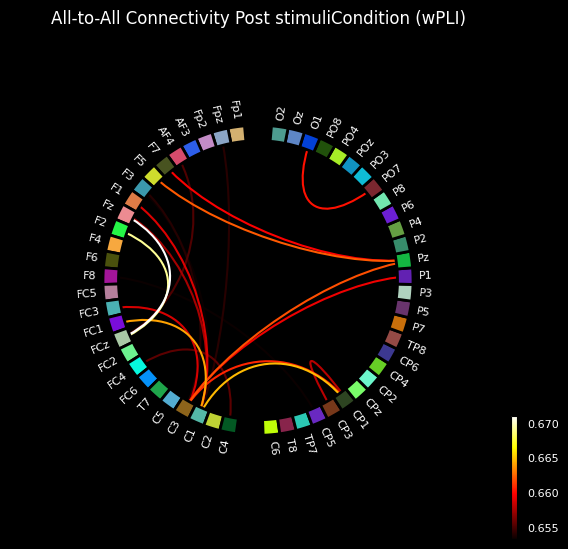

In [16]:
# First we need a node colors
import os.path as op

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne import make_forward_solution, setup_source_space, setup_volume_source_space
from mne.datasets import sample
from mne.io import read_raw_fif
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.viz import circular_layout

from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

import random


def generate_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        r = round(random.random(), 3)
        g = round(random.random(), 3)
        b = round(random.random(), 3)
        a = 1.0  # Keeping alpha at 1.0 for full opacity
        colors.append((r, g, b, a))
    return colors


# For our cases right now we can use same order of label_names
label_names = pre_raws[0].ch_names
node_order = label_names

# Second we need to define Node Angle
node_angles = circular_layout(
    label_names, node_order, start_pos=90, group_boundaries=[0, len(label_names) // 2]
)


node_colors = generate_colors(len(label_names))

# Third we're gonna need a connection matrix which we already calculate it

# Here we're gonna only use channel names as demonstrator

fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
# plot_connectivity_circle(
#     pre_con_wpli.get_data("dense")[:, :, 0],
#     label_names,
#     n_lines=20,
#     node_angles=node_angles,
#     node_colors=node_colors,
#     title="All-to-All Connectivity Pre stimuli" "Condition (wPLI)",
#     ax=ax,
# )

plot_connectivity_circle(
    post_con_wpli.get_data("dense")[:, :, 0],
    label_names,
    n_lines=20,
    node_angles=node_angles,
    node_colors=node_colors,
    title="All-to-All Connectivity Post stimuli" "Condition (wPLI)",
    ax=ax,
)
fig.tight_layout()